In [21]:
# builds on functions by Lars Bonne and his already prepared data to determine a full FIR (40-500micron) intensity in order to compare it to the CII intensity from the same region
# it does so by performing a modified blackbody SED (greybody) fit. The output is stored in a .csv file for plotting, creates .fits maps for the regions
# see https://github.com/lmlb-astro/CII_intensity_correlations/tree/main for more information on code which was butchered for some core functions
# plotting script of this output is 'correlation_CII_FIR_full_regions.ipynb'
# by S. Dannhauer, 2024

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy import units as u
from scipy.optimize import curve_fit
from scipy.integrate import simps
import astropy.constants as const
import pandas as pd
import concurrent.futures
from datetime import datetime

In [23]:
#### User input ####
## information to fetch the necessary data

dir_path = "data_CIIcorr/data_FEEDBACK/36arcsec_res" ## path to the data 

data_files = {
    'CII': "_upGREAT_CII_36_8_integrated",   #10px border removed for CII to get rid of border effects in 36" data, associated function "remove_border_and_save"
    '70m': "_Herschel_PACS_70_36_8",
    '100m': "_Herschel_PACS_100_36_8",
    '160m': "_Herschel_PACS_160_36_8",
    '250m': "_Herschel_SPIRE_250_36_8",
    '350m': "_Herschel_SPIRE_350_36_8",
    '500m': "_Herschel_SPIRE_500_36_8",
    '3p6': "_Spitzer_IRAC_3p6_36_8",
    '4p5': "_Spitzer_IRAC_4p5_36_8",
    '5p8': "_Spitzer_IRAC_5p8_36_8",
    '8m': "_Spitzer_IRAC_8_36_8"
}

plot_path = "plots_SED" ## path to the plot directory
os.makedirs(plot_path, exist_ok=True)

list_regions = [ ## list of the regions to be studied
    #"CYGNUSX",
    #"M16",
    #"M17",
    #"NGC7538",
    #"RCW36",
    #"RCW49",
    #"RCW79",
    "RCW120",
    #"W40",
    #"ORIONA" 
]

#Select wavelengths used in SED fit
wavelengths = {
        '70m': 70,
        #'100m': 100,
        '160m': 160,
        '250m': 250,
        '350m': 350,
        '500m': 500,
        #'3p6': 3.6,
        #'4p5': 4.5,
        #'5p8': 5.8,
        #'8m': 8
    }

#Switch: Select if you want to plot a flux overview for each region
plot_flux_overview = True

#Switch on to save individual SED plots/fits, creates a lot of plots, circa 300MB per region
save_plots = False 

#Swich: Select the border size that is cut away and if you want to crop the image. 
do_and_use_cutout = True
border_size = 10 #pixels

#Fixed emissivity index for the dust, follows Pabst et al. 2020, can be lower 
beta_fixed = 2.0

In [24]:
# Function to remove border and save cutout
def remove_border_and_save(region, data_type, border_size):
    input_file = os.path.join(dir_path, region, region + data_files[data_type] + '.fits')
    output_file = os.path.join(dir_path, region, region + data_files[data_type] + '_cutout.fits')

    with fits.open(input_file) as hdul:
        data = hdul[0].data
        trimmed_data = data[border_size:-border_size, border_size:-border_size]
        hdul[0].data = trimmed_data
        hdul.writeto(output_file, overwrite=True)

    print(f"Processed {input_file} and saved cutout as {output_file}")

# Function to read data into DataFrame
def read_data_to_df(paths, region):
    data_dict = {}
    ra_coords = None
    dec_coords = None
    data_shape = None
    header_info = None  # Placeholder for header information

    for key, name in paths.items():
        file_path = os.path.join(dir_path, region, region + name + ("_cutout.fits" if do_and_use_cutout else ".fits"))
        
        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            continue
        
        hdu = fits.open(file_path)
        data = hdu[0].data
        if header_info is None:  # Store header information from the first file
            header_info = hdu[0].header.copy()
        
        if key == 'CII':
            wcs = WCS(hdu[0].header)
            data_shape = data.shape
            ny, nx = data_shape
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            ra_coords, dec_coords = wcs.all_pix2world(x, y, 0)
            ra_coords = ra_coords.ravel()
            dec_coords = dec_coords.ravel()

        data = data.ravel()
        data = data.astype(np.float64, copy=False)
        
        data_dict[key] = data

    min_len = min(len(arr) for arr in data_dict.values())
    for key in data_dict:
        data_dict[key] = data_dict[key][:min_len]

    df = pd.DataFrame(data_dict)

    if ra_coords is not None and dec_coords is not None:
        df['RA_J2000'] = ra_coords[:min_len]
        df['Dec_J2000'] = dec_coords[:min_len]
            
    df = df.dropna()
    return df, data_shape, header_info

# Modified blackbody function
def modified_blackbody(wavelength, tau_160, T_dust, beta=beta_fixed):
    wavelength_meter = wavelength * 1e-6
    B_lambda = (2 * const.h.value * const.c.value**2) / (wavelength_meter**5) * 1 / (np.exp(const.h.value * const.c.value / (const.k_B.value * T_dust * wavelength_meter)) - 1) * 1e6
    I_lambda = B_lambda * (1 - np.exp(-tau_160 * (160 / wavelength)**beta))
    return I_lambda

# Function to plot flux overview
def plot_flux_overview(df, region):
    if plot_flux_overview:
        plt.figure(figsize=(12, 8))

        for key, wavelength in wavelengths.items():
            if key in df.columns:
                x = np.full_like(df[key], wavelength, dtype=np.float64)  # Use wavelength in microns
                y = df[key]
                
                # Plot the data
                plt.plot(x, y, 'o', label=f'{wavelength} µm')
                
        plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick size
        plt.xlabel('$\lambda [\mu m]$', fontsize=20)
        plt.ylabel('$F_{\lambda}$ [MJy sr$^{-1}$]', fontsize=20)        
        plt.yscale('log')
        plt.title(f'Wavelength vs. Flux density for region {region}', fontsize=20)
        plt.grid(True)
        plt.legend()
    
    # Save the plot
    plot_filename = os.path.join(plot_path, f"flux_overview_{region}.pdf")
    plt.savefig(plot_filename)
    print(f"Saved flux overview plot for {region} as {plot_filename}")
    
    # Display the plot (optional, depending on your use case)
    plt.show()

# Function to plot SED fit for each row
def plot_sed_fit(region, index, x_data, y_data, fitted_y):
    if save_plots:
        plt.figure(figsize=(12, 8))
        plt.scatter(x_data, y_data, label='Observed Data', alpha=0.7)
        if fitted_y is not None:
            plt.plot(np.linspace(40, 500, 1000), fitted_y, label='Fitted Curve', color='red')
        plt.xlabel('$\lambda [\mu m]$', fontsize=20)
        plt.ylabel('$F_{\lambda}$ [MJy sr$^{-1}$]', fontsize=20)  
        plt.yscale('log')
        plt.title(f'Wavelength vs. Flux density for region {region} - Line {index}', fontsize=20)
        plt.legend()
        plt.grid(True)
        
        # Save the plot
        plot_filename = os.path.join(plot_path, f"plot_with_fit_{region}_line_{index}.pdf")
        plt.savefig(plot_filename)
        plt.close()
        print(f"Saved plot for {region} line {index} as {plot_filename}")

# Fit a single row of data
def fit_row(index, row, wavelengths, beta_fixed):
    x_data = []
    y_data = []

    for key, wavelength in wavelengths.items():
        if key in row:
            x_data.append(wavelength)
            y_data.append(row[key])

    x_data = np.array(x_data, dtype=np.float64)
    y_data = np.array(y_data, dtype=np.float64)

    if len(x_data) > 1:
        try:
            popt, _ = curve_fit(modified_blackbody, x_data, y_data, p0=[0.002, 15], bounds=(0, [np.inf, np.inf]))
            tau_160_fit, T_dust_fit = popt
            wavelengths_fit = np.linspace(40, 500, 1000)
            fitted_y = modified_blackbody(wavelengths_fit, tau_160_fit, T_dust_fit, beta=beta_fixed)
            integrated_flux = simps(fitted_y, wavelengths_fit) / (500 - 40)
            return index, tau_160_fit, T_dust_fit, integrated_flux, x_data, y_data, fitted_y
        except Exception as e:
            print(f"Fit failed for index {index}: {e}")
            return index, np.nan, np.nan, np.nan, x_data, y_data, None
    else:
        return index, np.nan, np.nan, np.nan, x_data, y_data, None

# Process region data
def process_region(region, data_files, border_size, do_and_use_cutout):
    if do_and_use_cutout:
        for data_type in data_files.keys():
            remove_border_and_save(region, data_type, border_size)
    df, data_shape, header_info = read_data_to_df(data_files, region)
    
    # Plot flux overview before fitting
    plot_flux_overview(df, region)
    
    return df, data_shape, header_info

# Parallel processing and plotting function
def parallel_processing(do_and_use_cutout, list_regions, data_files, border_size):
    for region in list_regions:
        df, data_shape, header_info = process_region(region, data_files, border_size, do_and_use_cutout)
        
        df['tau_160_fit'] = np.nan
        df['T_dust_fit_in_K'] = np.nan
        df['FIR_flux_40_to_500'] = np.nan

        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(fit_row, index, row, wavelengths, beta_fixed): index for index, row in df.iterrows()}
            for future in concurrent.futures.as_completed(futures):
                index = futures[future]
                try:
                    result = future.result()
                    if len(result) == 7:
                        idx, tau_160_fit, T_dust_fit, integrated_flux, x_data, y_data, fitted_y = result
                        df.at[idx, 'tau_160_fit'] = tau_160_fit
                        df.at[idx, 'T_dust_fit_in_K'] = T_dust_fit
                        df.at[idx, 'FIR_flux_40_to_500'] = integrated_flux

                        # Plot SED fit for each row
                        plot_sed_fit(region, idx, x_data, y_data, fitted_y)
                    else:
                        print(f"Unexpected result length for index {index}: {len(result)}")
                except Exception as e:
                    print(f"Error processing index {index}: {e}")

        plot_filename = os.path.join(dir_path, f"data_with_fits_{region}.csv")

        # Create 2D arrays for tau_160, T_dust, and FIR_flux
        tau_2d = df['tau_160_fit'].values.reshape(data_shape)
        T_dust_2d = df['T_dust_fit_in_K'].values.reshape(data_shape)
        FIR_flux_2d = df['FIR_flux_40_to_500'].values.reshape(data_shape)

        # Create FITS HDUs and copy header information
        hdu_tau_160 = fits.PrimaryHDU(tau_2d, header=header_info)
        hdu_tau_160.header['AUTHOR'] = 'Simon Dannhauer'
        hdu_tau_160.header['DATE'] = datetime.now().strftime('%Y-%m-%d')
        hdu_tau_160.header['REGION'] = region
        hdu_tau_160.header['BUNIT'] = 'unitless'

        hdu_T_dust = fits.PrimaryHDU(T_dust_2d, header=header_info)
        hdu_T_dust.header['AUTHOR'] = 'Simon Dannhauer'
        hdu_T_dust.header['DATE'] = datetime.now().strftime('%Y-%m-%d')
        hdu_T_dust.header['REGION'] = region
        hdu_T_dust.header['BUNIT'] = 'K'

        hdu_FIR_flux = fits.PrimaryHDU(FIR_flux_2d, header=header_info)
        hdu_FIR_flux.header['AUTHOR'] = 'Simon Dannhauer'
        hdu_FIR_flux.header['DATE'] = datetime.now().strftime('%Y-%m-%d')
        hdu_FIR_flux.header['REGION'] = region
        hdu_FIR_flux.header['BUNIT'] = 'MJy/sr'

        # Leave these copied keywords empty, adjust as needed
        hdu_tau_160.header['LINE'] = ' '
        hdu_tau_160.header['ALTRPIX'] = ' '
        hdu_tau_160.header['ALTRVAL'] = ' '
        hdu_tau_160.header['RESTFREQ'] = ' '
        hdu_tau_160.header['IMAGFREQ'] = ' '
        hdu_tau_160.header['VELO-LSR'] = ' '
        hdu_tau_160.header['VELREF'] = ' '
        hdu_tau_160.header['SPECSYS'] = ' '
        hdu_tau_160.header['ORIGIN'] = ' '

        hdu_T_dust.header['LINE'] = ' '
        hdu_T_dust.header['ALTRPIX'] = ' '
        hdu_T_dust.header['ALTRVAL'] = ' '
        hdu_T_dust.header['RESTFREQ'] = ' '
        hdu_T_dust.header['IMAGFREQ'] = ' '
        hdu_T_dust.header['VELO-LSR'] = ' '
        hdu_T_dust.header['VELREF'] = ' '
        hdu_T_dust.header['SPECSYS'] = ' '
        hdu_T_dust.header['ORIGIN'] = ' '

        hdu_FIR_flux.header['LINE'] = ' '
        hdu_FIR_flux.header['ALTRPIX'] = ' '
        hdu_FIR_flux.header['ALTRVAL'] = ' '
        hdu_FIR_flux.header['RESTFREQ'] = ' '
        hdu_FIR_flux.header['IMAGFREQ'] = ' '
        hdu_FIR_flux.header['VELO-LSR'] = ' '
        hdu_FIR_flux.header['VELREF'] = ' '
        hdu_FIR_flux.header['SPECSYS'] = ' '
        hdu_FIR_flux.header['ORIGIN'] = ' '

        # Save the FITS files
        hdu_tau_160.writeto(os.path.join(dir_path, f"{region}_tau_160.fits"), overwrite=True)
        hdu_T_dust.writeto(os.path.join(dir_path, f"{region}_T_dust.fits"), overwrite=True)
        hdu_FIR_flux.writeto(os.path.join(dir_path, f"{region}_FIR_flux_40_500_microns.fits"), overwrite=True)

        print(f"Saved FITS files for region {region}")

Processed data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_upGREAT_CII_36_8_integrated.fits and saved cutout as data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_upGREAT_CII_36_8_integrated_cutout.fits
Processed data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_70_36_8.fits and saved cutout as data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_70_36_8_cutout.fits
Processed data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_100_36_8.fits and saved cutout as data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_100_36_8_cutout.fits
Processed data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_160_36_8.fits and saved cutout as data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_PACS_160_36_8_cutout.fits
Processed data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_SPIRE_250_36_8.fits and saved cutout as data_CIIcorr/data_FEEDBACK/36arcsec_res/RCW120/RCW120_Herschel_SPIRE_250_36

Saved flux overview plot for RCW120 as plots_SED/flux_overview_RCW120.pdf


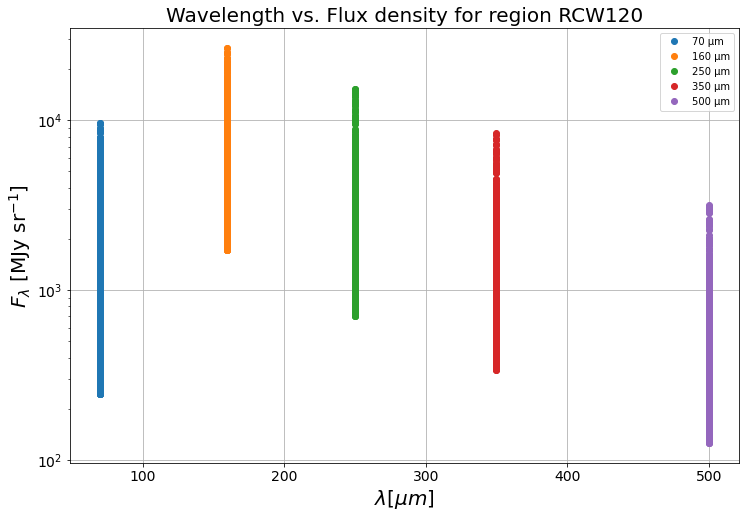

Fit failed for index 3679: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Saved FITS files for region RCW120


In [25]:
####################### MAIN but make it quick #############################
# Run the parallel processing
parallel_processing(do_and_use_cutout, list_regions, data_files, border_size)
#############################################################################
#The .csv has units of MJy/sr for the integrated fluxes, MJy/sr/Hz for flux density, K for temperature and unitless for tau.